## Assignment week 05: Sleeping habits

Welcome to **week five** of this course programming 1. You will learn about analysing data with pandas and numpy and you will learn to visualize with bokeh. Concretely, you will preprocess the Sleep Study data in an appropiate format in order to conduct statistical and visual analysis. Learning outcomes:


## About the data

The data is collected from a survey-based study of the sleeping habits of individuals within the US. 

Below is a description of each of the variables contained within the dataset.

- Enough = Do you think that you get enough sleep?
- Hours = On average, how many hours of sleep do you get on a weeknight?
- PhoneReach = Do you sleep with your phone within arms reach?
- PhoneTime = Do you use your phone within 30 minutes of falling asleep?
- Tired = On a scale from 1 to 5, how tired are you throughout the day? (1 being not tired, 5 being very tired)
- Breakfast = Do you typically eat breakfast?

The two research questions you should answer in this assignment are:
1. Is there a differences in Hours sleep caused by having breakfast (yes, no)?
2. Is there a differences in Hours sleep caused by having breakfast and the tireness (score)


The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: data inspection](#1)
- [part 3: check assumptions](#2)
   - [check normality 3.1](#ex-31)
   - [check equal variance 3.2](#ex-32)
- [part 4: prepare the data](#3)
- [part 5: answer the research question](#4)
- [part 6: enhanced plotting](#5)

Part 1 till 5 are mandatory, part 6 is optional (bonus)
To pass the assingnment you need to a score of 60%. 


**NOTE If your project data is suitable you can use that data instead of the given data**

## ANOVA

Analysis of variance (ANOVA) compares the variances between groups versus within groups. It basically determines whether the differences between groups is larger than the differences within a group (the noise). 
A graph picturing this is as follow: https://link.springer.com/article/10.1007/s00424-019-02300-4/figures/2


In ANOVA, the dependent variable must be a continuous (interval or ratio) level of measurement. For instance Glucose level. The independent variables in ANOVA must be categorical (nominal or ordinal) variables. For instance trial category, time of day (AM versus PM) or time of trial (different categories). Like the t-test, ANOVA is also a parametric test and has some assumptions. ANOVA assumes that the data is normally distributed.  The ANOVA also assumes homogeneity of variance, which means that the variance among the groups should be approximately equal. ANOVA also assumes that the observations are independent of each other. 

A one-way ANOVA has just one independent variable. A two-way ANOVA (are also called factorial ANOVA) refers to an ANOVA using two independent variables. For research question 1 we can use the one-way ANOVA, for research question two we can use two-way ANOVA. But first we need to check the assumptions. 


---

<a name='0'></a>
## Part 1: Load the data (10 pt)

load the `sleep.csv` data. Get yourself familiar with the data. Answer the following questions.

1. What is the percentage missing data?
2. Considering the research question, what is the dependent variable and what are the indepent variables? Are they of the correct datatype? 

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import panel as pn
import pathlib
import seaborn as sns
import yaml

from bokeh.models import ColumnDataSource, Band, HoverTool, Span, Label
from bokeh.models.formatters import DatetimeTickFormatter
from bokeh.plotting import figure, output_notebook, show
from bokeh.io import curdoc
from bokeh.layouts import gridplot
from scipy.stats import norm, iqr, shapiro, levene, bartlett

pn.extension()

In [43]:
def get_filepath():
    with open('config.yaml', 'r') as stream:
        config = yaml.safe_load(stream)
        
    return config['datadir']

data_dir = get_filepath()
file_name = 'sleep.csv'
file_path = pathlib.Path(data_dir, file_name)

df = pd.read_csv(file_path)
df.head()

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,Yes,8.0,Yes,Yes,3,Yes
1,No,6.0,Yes,Yes,3,No
2,Yes,6.0,Yes,Yes,2,Yes
3,No,7.0,Yes,Yes,4,No
4,No,7.0,Yes,Yes,2,Yes


First inspecting all the possible values a column can have

In [44]:
options = {
    'Enough': None,
    'Hours': None,
    'PhoneReach': None,
    'PhoneTime': None,
    'Tired': None,
    'Breakfast': None
}
for k in options.keys():
    options[k] = df[k].unique()
    
for k, v in options.items():
    print('Variable "{}" has the following options: {}.'.format(k, v))

Variable "Enough" has the following options: ['Yes' 'No'].
Variable "Hours" has the following options: [ 8.  6.  7.  4. 10.  9.  2.  5. nan].
Variable "PhoneReach" has the following options: ['Yes' 'No'].
Variable "PhoneTime" has the following options: ['Yes' 'No'].
Variable "Tired" has the following options: [3 2 4 5 1].
Variable "Breakfast" has the following options: ['Yes' 'No'].


As we can see, the `Hours` column contains `nan` values. Furthermore, there are no empty values, thus we only have to count the nan values to determine the amount of missing data. The rest of the values look plausible.

In [45]:
#code printing percentage missing data
n_nan = df.isna().sum().sum()

print('In total {:.2f}% data is missing.\n'.format(n_nan / df.size * 100))
print('Every columns has {} observations. Missing values per column:'.format(df.shape[0]))
print(df.isna().sum())

In total 0.32% data is missing.

Every columns has 104 observations. Missing values per column:
Enough        0
Hours         2
PhoneReach    0
PhoneTime     0
Tired         0
Breakfast     0
dtype: int64


Since we are missing two values, we inspect those values

In [46]:
df[df['Hours'].isna()]

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
65,No,NaN,Yes,No,3,Yes
91,Yes,NaN,No,Yes,2,Yes


We can see that the subjects containing NaN values did have breakfast. 

So we will fill the NaN values with the median (as it looks like there are some outliers) of Hours.

In [47]:
df.loc[65, ('Hours')] = np.nanmedian(df[(df['Breakfast'] == 'Yes') 
   & (df['PhoneReach'] == 'Yes')
   & (df['PhoneTime'] == 'No')
   & (df['Tired'] == 3)]['Hours'])

df.iloc[65]

Enough         No
Hours           6
PhoneReach    Yes
PhoneTime      No
Tired           3
Breakfast     Yes
Name: 65, dtype: object

In [58]:
df.loc[91, ('Hours')] = np.nanmedian((df[(df['Breakfast'] == 'Yes') 
   & (df['PhoneReach'] == 'No')
   & (df['PhoneTime'] == 'Yes')
   & (df['Tired'] == 2)])['Hours'])

df.loc[91]

Enough        Yes
Hours           7
PhoneReach     No
PhoneTime     Yes
Tired           2
Breakfast     Yes
Name: 91, dtype: object

---------
The two research questions you should answer in this assignment are:

- Is there a differences in Hours sleep caused by having breakfast (yes, no)?
- Is there a differences in Hours sleep caused by having breakfast and the tireness (score)

Based on the first question, the **independent variable** will be `breakfast` and the **dependent variable** will consist of `Hours` of sleep.

Based on the second question, the **independent variables** will be `breakfast` and `Tired`, while the **dependent variable** will be `Hours`.

In [2]:
#code printing answer dependent and independent variables

In [59]:
#code printing answer about datatypes
df.dtypes

Enough         object
Hours         float64
PhoneReach     object
PhoneTime      object
Tired           int64
Breakfast      object
dtype: object

---

<a name='1'></a>
## Part 2: Inspect the data (30 pt)

Inspect the data practically. Get an idea about how well the variable categories are ballanced. Are the values of a variable equally divided? What is the mean value of the dependent variable? Are there correlations amongs the variables?


<ul>
<li>Create some meaninful overviews such as variable value counts</li>
<li>Create a scatter plot ploting the relation between being tired and hours of sleep with different colors for Breakfast</li>
    <li>Print some basic statistics about the target (mean, standard deviation)</li>
    <li>Create a heatmap to check for correlations among variables. </li>

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>the gitbook has a bokeh heatmap example</li></ul>
</details>
</ul>

<AxesSubplot:xlabel='Tired', ylabel='Frequency of hours of sleep'>

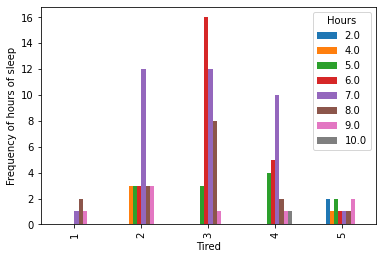

In [68]:
#code your answer to the value counts and distribution plots here
hours_tired = df.value_counts(subset=['Tired', 'Hours']).sort_index(ascending=False)
hours_tired.unstack().plot(kind='bar', ylabel='Frequency of hours of sleep')

From a first visual inspection we can state the following:
- Subjects that are not that tired (2) are sleeping mostly 7 hours.
- Subjects that are a neutral (3) are sleeping mostly for 8, 7 or 6 hours.
- Subjects that are a bit tired (4) are sleeping mostly for 7, 6, or 5 hours. 

<AxesSubplot:xlabel='Breakfast', ylabel='Frequency of hours of sleep'>

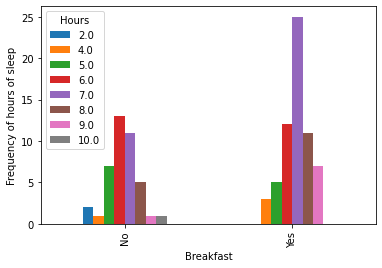

In [71]:
hours_breakfast = df.value_counts(subset=['Breakfast', 'Hours']).sort_index(ascending=False)
hours_breakfast.unstack().plot(kind='bar', stacked=False, ylabel='Frequency of hours of sleep')

From a quick glance, we can see, that most people that eat breakfast sleep for 7 hours.

In [132]:
source = ColumnDataSource(df)

p = figure(width=400, height=400, tools="pan,wheel_zoom,box_zoom,reset")
p.circle(x='Tired', y='Hours', size=20, color='navy', alpha=0.1, source=source)

p.xaxis.axis_label = 'Tiredness score'
p.yaxis.axis_label = 'Hours of sleep'
p.yaxis[0].ticker.desired_num_ticks = 10

show(p)

Clearly, the tiredness score and hours of sleep have a tendency to be between 2 and 4 and between 6 and 8 respectively.

**Heatmap**

It's easiest to work with numbers. The `Enough`, `PhoneReach`, `PhoneTime` and `Breakfast` column have the same categorical choice of choosing 'Yes' or 'No'. We can use this fact to convert it into a binary format, i.e. 0 and 1. In this way we can use it for a correlation analysis.

In [133]:
def categorical_to_number(row):
    if isinstance(row, str):
        if row == 'Yes':
            return 1
        elif row == 'No':
            return 0
        
    return row


df[['Enough', 'PhoneReach', 'PhoneTime', 'Breakfast']] = df[['Enough', 'PhoneReach', 'PhoneTime', 'Breakfast']].applymap(categorical_to_number)
df.head()

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
0,1,8.0,1,1,3,1
1,0,6.0,1,1,3,0
2,1,6.0,1,1,2,1
3,0,7.0,1,1,4,0
4,0,7.0,1,1,2,1


Now the data is ready to be analyzed using a correlation matrix. The `df.corr` method excludes NA/null values.

<AxesSubplot:>

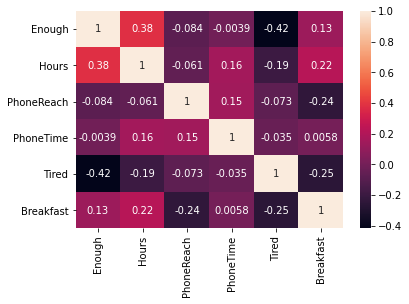

In [134]:
sns.heatmap(df.corr(method='pearson'), annot=True)

The correlation coefficient can range from -1 to +1. The closer to -1 or +1, the stronger the negative or positive correlation respectively.

The degree of correlation can be interpreted in the following way:
- **Perfect** if $d \pm 1$.
- **High degree** if $0.5 < d < 1$
- **Moderate degree** if $0.3 < 0.5$
- **Low degree** if $0.0 < d < 0.3$
- **No correlation** if $ d \pm 0$

https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/pearsons-correlation-coefficient/

Based on the heatmap, we can draw the following conclusions regarding the research questions:
- The amount of `Hours` of sleep has a **low degree** of positive correlation with having `Breakfast`.
- The amount of `Hours` of sleep has a **low degree** of negative correlation with the feeling of being `Tired`.
- Feeling `Tired` has a **moderate degree** of negative correlation with `Breakfast`. 

---

<a name='2'></a>
## Part 3: Check Assumptions

Before we answer the research question with ANOVA we need to check the following assumptions:

1. ANOVA assumes that the dependent variable is normaly distributed
2. ANOVA also assumes homogeneity of variance
3. ANOVA also assumes that the observations are independent of each other. Most of the time we need domain knowledge and experiment setup descriptions to estimate this assumption

We are going to do this graphically and statistically. 

<a name='ex-31'></a>
### Check normality (10 pt)

<ul><li>
Plot the distribution of the dependent variable. Add a vertical line at the position of the average. Add a vertical line for the robuust estimation. Add the normal distribution line to the plot. Comment on the normallity of the data. Do you want the full points? Plot with bokeh!</li>

<li>Use a Shapiro-Wilk Test or an Anderson-Darling test to check statistically</li></ul>


<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>check the code of lesson 1 DS1 bayesian statistics</li>
        <li>heart_failure case of gitbook uses bokeh histograms</li>
</ul>
</details>

We can assume that the dependent variable, hours of sleep, follows a normal distribution, such that $y$ ~ $N(\mu, \sigma^2)$. This is based on *Internal Time* from *Till Ronenneberg* who used the distribution of midsleep in Central Europe, containing approximately 100.000 participants (predominantly Germans).

At the moment we are only dealing with discrete values. The amount of Hours will be an integer between 2 and 10 (including). Therefore, we can use a binomial distribution and plot it as a Normal distribution. 

In [293]:
have_breakfast = df[df['Breakfast'] == 1]
have_breakfast = have_breakfast[['Hours', 'Breakfast']]

skip_breakfast = df[df['Breakfast'] == 0]
skip_breakfast = skip_breakfast[['Hours', 'Breakfast']]

In [294]:
have_breakfast.shape

(63, 2)

In [295]:
skip_breakfast.shape

(41, 2)

As can be seen, there is already an imbalance. 60% of the subjects had breakfast, and 40% skipped breakfast.

In [362]:
# The Shapiro-Wilk test, tests the null hypothesis that the data 
# was drawn from a normal distribution

def shapiro_test(df):
    hours = df['Hours'] 
    statistic, p_value = shapiro(hours)
    print('Statistic={:.3f}, p-value={}'.format(statistic, p_value))
    
    # Assuming a=0.05
    # H0: the distribution is Gaussian
    # H1: the distribution is not Gaussian
    alpha = 0.05
    if p_value > alpha:
        print('The distribution is Gaussian')
    else:
        print('The distribution is not Gaussian')
    
shapiro_test(have_breakfast)
shapiro_test(skip_breakfast)

Statistic=0.922, p-value=0.0006609632400795817
The distribution is not Gaussian
Statistic=0.920, p-value=0.00669891107827425
The distribution is not Gaussian


The shapiro test seems to be sure that the distribution is not Gaussian. This may be true, as the distribution can be better expressed as a binomial distribution, due to the discrete data.

Let's inspect the data using a Q_Q_Plot to check if we can visually conclude if it looks like a normal distribution.

In [363]:
def Q_Q_Plot(y, est = 'robust', **kwargs):
    
    ################################################################################
    #
    # Arguments:
    #
    # y                  data array
    # est                Estimation method for normal parameters mu and sigma:
    #                    either 'robust' (default), or 'ML' (Maximum Likelihood),
    #                    or 'preset' (given values)
    # If est='preset' than the optional parameters mu, sigma must be provided
    #
    # Author:            M.E.F. Apol
    # Date:              2020-01-06
    #
    ################################################################################
    
    import numpy as np
    from scipy.stats import iqr # iqr is the Interquartile Range function
    import matplotlib.pyplot as plt
    
    # First, get the optional arguments mu and sigma:
    mu_0 = kwargs.get('mu', None)
    sigma_0 = kwargs.get('sigma', None)
    
    n = len(y)
    
    # Calculate order statistic:
    y_os = np.sort(y)
  
    # Estimates of mu and sigma:
    # ML estimates:
    mu_ML = np.mean(y)
    sigma2_ML = np.mean((y - mu_ML)**2)
    sigma_ML = np.sqrt(sigma2_ML) # biased estimate
    s2 = n/(n-1) * sigma2_ML
    s = np.sqrt(s2) # unbiased estimate
    # Robust estimates:
    mu_R = np.median(y)
    sigma_R = iqr(y)/1.349

    # Assign values of mu and sigma for z-transform:
    if est == 'ML':
        mu, sigma = mu_ML, s
    elif est == 'robust':
        mu, sigma = mu_R, sigma_R
    elif est == 'preset':
        mu, sigma = mu_0, sigma_0
    else:
        print('Wrong estimation method chosen!')
        
    print('Estimation method: ' + est)
    print('mu = ',mu,', sigma = ',sigma)
        
    # Perform z-transform: sample quantiles z.i
    z_i = (y_os - mu)/sigma

    # Calculate cumulative probabilities p.i:
    i = np.array(range(n)) + 1
    p_i = (i - 0.5)/n

    # Calculate theoretical quantiles z.(i):
    from scipy.stats import norm
    z_th = norm.ppf(p_i, 0, 1)

    # Calculate SE or theoretical quantiles:
    SE_z_th = (1/norm.pdf(z_th, 0, 1)) * np.sqrt((p_i * (1 - p_i)) / n)

    # Calculate 95% CI of diagonal line:
    CI_upper = z_th + 1.96 * SE_z_th
    CI_lower = z_th - 1.96 * SE_z_th

    # Make Q-Q plot:
    plt.plot(z_th, z_i, 'o', color='k', label='experimental data')
    plt.plot(z_th, z_th, '--', color='r', label='normal line')
    plt.plot(z_th, CI_upper, '--', color='b', label='95% CI')
    plt.plot(z_th, CI_lower, '--', color='b')
    plt.xlabel('Theoretical quantiles, $z_{(i)}$')
    plt.ylabel('Sample quantiles, $z_i$')
    plt.title('Q-Q plot (' + est + ')')
    plt.legend(loc='best')
    plt.show()
    return();

Estimation method: ML
mu =  6.904761904761905 , sigma =  1.2535663410560174


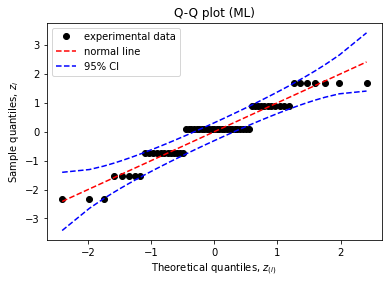

()

In [163]:
Q_Q_Plot(have_breakfast['Hours'], est='ML')

Estimation method: ML
mu =  6.2682926829268295 , sigma =  1.5495868843647076


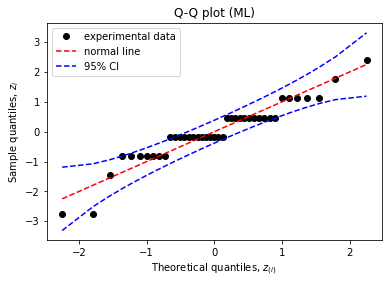

()

In [364]:
Q_Q_Plot(skip_breakfast['Hours'], est='ML')

According to the Q-Q plots, the data does follow a normal distribution. To check whether we can plot the data as a normal distribution, using a binomial distribution we can use another plot.

In [368]:
def plot_bin(hours, title):
    
    from scipy.stats import binom, norm

    min_value = hours.min()
    hours = hours - min_value # to make sure the first value is 0.

    k = hours.unique().size
    p = (1/k) * hours.mean()
    mu = hours.mean()
    sigma = np.sqrt(k * p * (1 - p))

    i = list(range(k))
    x = np.linspace(np.min(i),np.max(i)+1,501)
    f_i = binom.pmf(i, k, p)
    f_N = norm.pdf(x, mu, sigma)

    plt.vlines(i, 0, f_i, colors='k', linestyles='-', lw=1,label='$Bin(${:d}, {:.3f}$)$ distribution'.format(k, p))
    plt.plot(x, f_N, 'r', label='$N(${:.3f}, {:.3f}$)$ approximation'.format(mu, sigma**2))
    plt.xlabel('Hours of sleep, $y$')
    plt.ylabel('Probability, $f(y)$')
    plt.title(title)
    plt.legend(loc='best')

    xticks = np.arange(0, k)
    xticks_label = (xticks + min_value).astype('int')

    plt.xticks(xticks, xticks_label)
    plt.show()

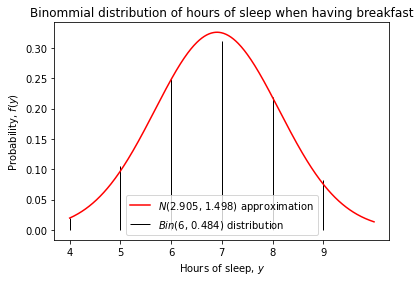

In [369]:
hours = have_breakfast['Hours'].copy()
title = 'Binommial distribution of hours of sleep when having breakfast'
plot_bin(hours, title)

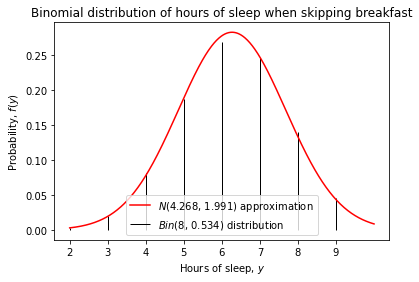

In [370]:
hours = skip_breakfast['Hours'].copy()
title = 'Binomial distribution of hours of sleep when skipping breakfast'
plot_bin(hours, title)

It can clearly be seen that the distribution of hours of sleep can be plotted as a normal distribution, using a binomial distribution.

<a name='ex-32'></a>
### Check homogeneity of variance (20 pt)

<ul><li>
Use boxplots for the check of homoegeneity of variance. Do you want the full points? Plot with bokeh!</li>

<li>Use a Levene’s & Bartlett’s Test of Equality (Homogeneity) of Variance to test equal variance statistically</li><ul>

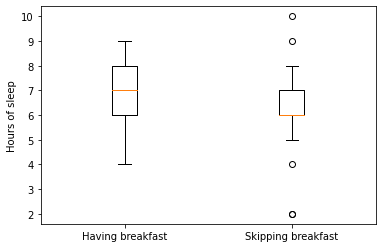

In [493]:
# your code to plot here
hb = have_breakfast['Hours']
hs = skip_breakfast['Hours']

plt.boxplot([hb, hs], labels=['Having breakfast', 'Skipping breakfast'])
plt.ylabel('Hours of sleep')
plt.show()

In [445]:
# your code for the statistical test here
from scipy.stats import levene, bartlett

hb = have_breakfast['Hours']
hs = skip_breakfast['Hours']

def conclusion(test, p_val):
    if p_val < 0.05:
        print('{}: The populations do not have equal variances.'.format(test))
    else:
        print('{}: The populations have equal variances.'.format(test))
    
# I am using the mean as a central tendency measure, bebcause that was proposed
# in the original article of Levene:  In Contributions to Probability and Statistics: Essays in Honor of Harold Hotelling, I.
_, p = levene(hb, hs, center='mean')
conclusion('levene' ,p)

_, p = bartlett(hb, hs)
conclusion('bartlett', p)

levene: The populations have equal variances.
bartlett: The populations have equal variances.


**Summary**

The data can be plotted as a normal distribution, through a binomial distribution. Therefore, we can state that the follows a normal distribution. This finding is also in agreement with the literature. 

The variances are equal, as concluded by using the levene and bartlett statistical tests. 

By comparing the median values in the boxplots, we can also conclude that the groups are similar, but have some differences. There are several outliers for the groups that do not eat breakfast. In general, when skipping breakfast, subjects have 1 hour less sleep in comparison with subjects who are having breakfast.

---

<a name='3'></a>
## Part 4: Prepare your data (10 pt)

Create a dataframe with equal samplesize. Make three categories for tireness 1-2 = no, 3 = maybe, 4-5 = yes

In [452]:
def tiredness_cat(row):
    if row < 3:
        return 'no'
    if row == 3:
        return 'maybe'
    else:
        return 'yes'
df['Tired'] = df['Tired'].agg(tiredness_cat)

In [459]:
df[df['Tired'] == 'no']

,Enough,Hours,PhoneReach,PhoneTime,Tired,Breakfast
2,1,6.0,1,1,no,1
4,0,7.0,1,1,no,1
8,0,4.0,0,1,no,1
11,0,7.0,1,1,no,1
13,1,8.0,1,1,no,0
21,0,4.0,1,1,no,1
24,0,5.0,1,1,no,0
27,0,6.0,1,1,no,0
28,1,7.0,1,0,no,1
29,1,9.0,0,0,no,1


---

<a name='4'></a>
## Part 5: Answer the research questions (20 pt)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
    <ul><li>use one-way ANOVA for research question 1</li>
    <li>Use two-way ANOVA for research question 2</li>
    <li>https://reneshbedre.github.io/blog/anova.html</li>
</ul>
</details>

In [468]:
def conclusion(test, p_val):
    if p_val < 0.05:
        print('{}: There is a significant difference between the groups.'.format(test))
    else:
        print('{}: There is no significant difference between the groups.'.format(test))

In [494]:
# To make sure they have the same sample size 
hb = hb.tolist()
for i in range(22):
    random_index = np.random.randint(0, len(arr))
    hb.pop(random_index)
hb = np.array(hb)

In [498]:
# one-way ANOVE for research question 1
from scipy.stats import f_oneway

# hours of subjects who had breakfast (hb) and hours of subjects who skipped breakfast (hs)
_, p = f_oneway(hb, hs)

conclusion('One way ANOVA', p)

One way ANOVA: There is a significant difference between the groups.


In [ ]:
# two way anova

---

<a name='5'></a>
## Part 6: Enhanced plotting (20 pt)

Create a panel with 1) your dataframe with equal samplesize 2) a picture of a sleeping beauty, 3) the scatter plot of tired / hours of sleep with different colors for Breakfast from part 2 4) the boxplots given the p-value for the anova outcome in the title

In [15]:
#your solution here